# 姓名：尤敬斌
# 学号：2019141420246

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_batch_size = 100    #每批处理的训练集数据
test_batch_size = 100     #每批处理的测试集数据
learning_rate = 0.001     #学习率
num_epoches = 50         #训练数据集的轮次

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                                               # 归一化
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # 标准化
])

In [4]:
train_valid_cifar10 = torchvision.datasets.CIFAR10(
    root='datasets',
    train=True,
    download=True,
    transform=transform
)
test_cifar10 = torchvision.datasets.CIFAR10(
    root='datasets',
    train=False,
    download=True,
    transform=transform
)
print(train_valid_cifar10)
print(test_cifar10)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [5]:
#分割数据集
lengths = [len(train_valid_cifar10)-5000,5000]
train_cifar10,valid_cifar10 = torch.utils.data.random_split(train_valid_cifar10,lengths)

In [6]:
#训练集
train_loader = torch.utils.data.DataLoader(train_cifar10, batch_size=train_batch_size, shuffle=True)
#验证集
valid_loader = torch.utils.data.DataLoader(valid_cifar10, batch_size=train_batch_size, shuffle=True)
#测试集
test_loader = torch.utils.data.DataLoader(test_cifar10, batch_size=test_batch_size, shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self,num_classes=10):
        super(Net,self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(32*32*3,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Linear(64,num_classes),
        )
    def forward(self,x):
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x
        

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
print(model)

Net(
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [9]:
# 损失器
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0001) 

In [10]:
train_loss = []          
test_loss = []
valid_loss = []
train_acc  = []    
valid_acc = [] 
test_acc  = []     

In [12]:
for epoch in range(num_epoches):
    print('epoch:',epoch+1)

    model.train()
    running_loss = 0.0        # 损失
    correct = 0               # 预测正确的个数
    total = 0                 # 总样本个数
    for _,data in enumerate(train_loader,0):
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, -1, 32, 32)  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 每次训练梯度清零
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
        total += labels.size(0)                   # 总样本个数加 1
        correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    train_loss.append(running_loss/total)
    train_acc.append(correct / total)
    print("训练集上的损失：%.3f" % (running_loss / total))
    print("训练集上的准确率：%.3f" % (correct / total))

    model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(valid_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    valid_loss.append(running_loss / total)
    valid_acc.append(correct / total)
    print("验证集上的损失：%.3f" % (running_loss / total))
    print("验证集上的准确率：%.3f" % (correct / total))
    
    model.eval()
    running_loss = 0.0
    correct = 0            
    total = 0             
    with torch.no_grad(): 
        for _,data in enumerate(test_loader,0):
            inputs, labels = data
            inputs = inputs.view(test_batch_size, -1, 32, 32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
            total += labels.size(0)                   # 总样本个数加 1
            correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1
    test_loss.append(running_loss / total)
    test_acc.append(correct / total)
    print("测试集上的损失：%.3f" % (running_loss / total))
    print("测试集上的准确率：%.3f" % (correct / total))

epoch: 1
训练集上的损失：0.023
训练集上的准确率：0.100
验证集上的损失：0.023
验证集上的准确率：0.105
测试集上的损失：0.023
测试集上的准确率：0.101
epoch: 2
训练集上的损失：0.023
训练集上的准确率：0.144
验证集上的损失：0.023
验证集上的准确率：0.189
测试集上的损失：0.023
测试集上的准确率：0.190
epoch: 3
训练集上的损失：0.022
训练集上的准确率：0.202
验证集上的损失：0.021
验证集上的准确率：0.237
测试集上的损失：0.021
测试集上的准确率：0.233
epoch: 4
训练集上的损失：0.021
训练集上的准确率：0.253
验证集上的损失：0.020
验证集上的准确率：0.273
测试集上的损失：0.020
测试集上的准确率：0.271
epoch: 5
训练集上的损失：0.019
训练集上的准确率：0.287
验证集上的损失：0.019
验证集上的准确率：0.305
测试集上的损失：0.019
测试集上的准确率：0.314
epoch: 6
训练集上的损失：0.018
训练集上的准确率：0.330
验证集上的损失：0.018
验证集上的准确率：0.346
测试集上的损失：0.018
测试集上的准确率：0.355
epoch: 7
训练集上的损失：0.017
训练集上的准确率：0.369
验证集上的损失：0.017
验证集上的准确率：0.379
测试集上的损失：0.017
测试集上的准确率：0.390
epoch: 8
训练集上的损失：0.016
训练集上的准确率：0.404
验证集上的损失：0.016
验证集上的准确率：0.413
测试集上的损失：0.016
测试集上的准确率：0.422
epoch: 9
训练集上的损失：0.016
训练集上的准确率：0.432
验证集上的损失：0.016
验证集上的准确率：0.429
测试集上的损失：0.016
测试集上的准确率：0.442
epoch: 10
训练集上的损失：0.015
训练集上的准确率：0.458
验证集上的损失：0.015
验证集上的准确率：0.439
测试集上的损失：0.015
测试集上的准确率：0.460
epoch: 11
训练集上的损失：0.014
训练集上的准确率：0.484


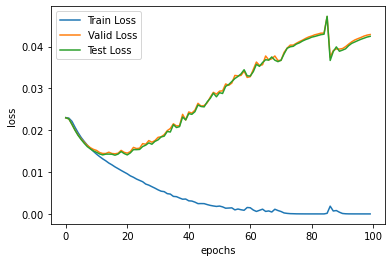

In [13]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(valid_loss)), valid_loss)
plt.plot(np.arange(len(test_loss)), test_loss)
plt.legend(['Train Loss','Valid Loss','Test Loss'])

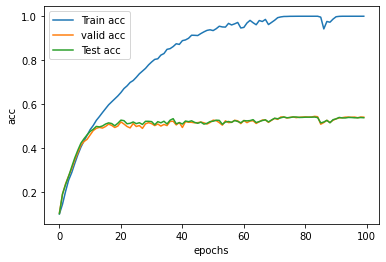

In [14]:
#准确率
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(np.arange(len(train_acc)), train_acc)
plt.plot(np.arange(len(valid_acc)), valid_acc)
plt.plot(np.arange(len(test_acc)), test_acc)
plt.legend(['Train acc','valid acc','Test acc'])

In [15]:
print('验证集最高准确率: ', max(valid_acc))
print('测试集最高准确率: ', max(test_acc))

验证集最高准确率:  0.544
测试集最高准确率:  0.5412


In [17]:
pos = valid_acc.index(max(valid_acc))
print('验证集最高准确率的模型对应的测试集准确率：', test_acc[pos])

验证集最高准确率的模型对应的测试集准确率： 0.5409
